In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

def get_n_params(model):
  np=0
  for p in list(model.parameters()):
    np += p.nelement()
  return np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
input_size  = 28*28
output_size = 10

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
        transform=transforms.Compose(
            [transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
             transforms.ToTensor(),
             transforms.Normalize((0.1307,), (0.3081,))])),
    batch_size=1000, shuffle=True)

100%|██████████| 9.91M/9.91M [00:01<00:00, 4.98MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 126kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 9.54MB/s]


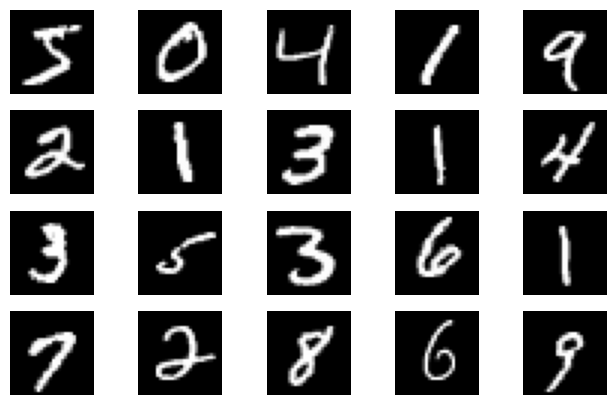

In [7]:
plt.figure(figsize=(8, 5))
for i in range(20):
    plt.subplot(4, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy(),'gray')
    plt.axis('off');

In [8]:
class FC2Layer(nn.Module):
  def __init__(self, input_size, n_hidden, output_size):

      super(FC2Layer, self).__init__()
      self.input_size = input_size
      self.network = nn.Sequential(
        nn.Linear(input_size, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, output_size),
        nn.LogSoftmax(dim=1)
      )

  def forward(self, x):

    x = x.view(-1, self.input_size)
    return self.network(x)

class CNN(nn.Module):
  def __init__(self, input_size, n_feature, output_size):

      super(CNN, self).__init__()

      self.n_feature = n_feature
      self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5)
      self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=5)
      self.fc1 = nn.Linear(n_feature*4*4, 50)
      self.fc2 = nn.Linear(50, 10)

  def forward(self, x, verbose=False):
      x = self.conv1(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = self.conv2(x)
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=2)
      x = x.view(-1, self.n_feature*4*4)
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = F.log_softmax(x, dim=1)

      return x

In [9]:
def train(model):
  model.train()

  for batch_idx, (data, target) in enumerate(train_loader):

    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 100 == 0:
      print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

def test(model):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:

        data, target = data.to(device), target.to(device)

        output = model(data)

        test_loss += F.nll_loss(output, target, reduction='sum').item()

        pred = output.data.max(1, keepdim=True)[1]

        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy))

In [10]:
n_hidden = 8
model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

train(model_fnn)
test(model_fnn)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.360977
Train: [6400/60000 (11%)]	Loss: 1.962216
Train: [12800/60000 (21%)]	Loss: 1.409456
Train: [19200/60000 (32%)]	Loss: 1.063736
Train: [25600/60000 (43%)]	Loss: 0.555882
Train: [32000/60000 (53%)]	Loss: 0.515634
Train: [38400/60000 (64%)]	Loss: 0.547306
Train: [44800/60000 (75%)]	Loss: 0.487921
Train: [51200/60000 (85%)]	Loss: 0.551026
Train: [57600/60000 (96%)]	Loss: 0.676240

Test set: Average loss: 0.4444, Accuracy: 8711/10000 (87%)



In [11]:

n_features = 6
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

train(model_cnn)
test(model_cnn)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.339114
Train: [6400/60000 (11%)]	Loss: 2.188580
Train: [12800/60000 (21%)]	Loss: 0.473328
Train: [19200/60000 (32%)]	Loss: 0.604167
Train: [25600/60000 (43%)]	Loss: 0.202750
Train: [32000/60000 (53%)]	Loss: 0.565423
Train: [38400/60000 (64%)]	Loss: 0.278614
Train: [44800/60000 (75%)]	Loss: 0.201671
Train: [51200/60000 (85%)]	Loss: 0.168406
Train: [57600/60000 (96%)]	Loss: 0.301435

Test set: Average loss: 0.2067, Accuracy: 9393/10000 (94%)



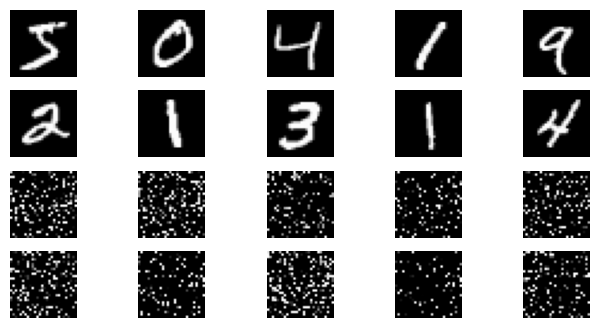

In [12]:
perm = torch.randperm(784)
plt.figure(figsize=(8, 4))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)

    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy(), 'gray')
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy(), 'gray')
    plt.axis('off')

In [16]:
def perm_pixel(data, perm):

    data_new = data.view(-1, 28*28)

    data_new = data_new[:, perm]

    data_new = data_new.view(-1, 1, 28, 28)
    return data_new

def train_perm(model, perm):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        data = perm_pixel(data, perm)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train: [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test_perm(model, perm):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        data = perm_pixel(data, perm)

        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item()
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [17]:
perm = torch.randperm(784)
n_hidden = 8
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

train_perm(model_fnn, perm)
test_perm(model_fnn, perm)

Number of parameters: 6442
Train: [0/60000 (0%)]	Loss: 2.449645
Train: [6400/60000 (11%)]	Loss: 0.534315
Train: [12800/60000 (21%)]	Loss: 0.410337
Train: [19200/60000 (32%)]	Loss: 0.449859
Train: [25600/60000 (43%)]	Loss: 0.427823
Train: [32000/60000 (53%)]	Loss: 0.409551
Train: [38400/60000 (64%)]	Loss: 0.249561
Train: [44800/60000 (75%)]	Loss: 0.323311
Train: [51200/60000 (85%)]	Loss: 0.267980
Train: [57600/60000 (96%)]	Loss: 0.336914

Test set: Average loss: 0.3889, Accuracy: 8886/10000 (89%)



In [18]:
perm = torch.randperm(784)

n_features = 6
model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

train_perm(model_cnn, perm)
test_perm(model_cnn, perm)

Number of parameters: 6422
Train: [0/60000 (0%)]	Loss: 2.320812
Train: [6400/60000 (11%)]	Loss: 2.280069
Train: [12800/60000 (21%)]	Loss: 2.178331
Train: [19200/60000 (32%)]	Loss: 1.861734
Train: [25600/60000 (43%)]	Loss: 1.614097
Train: [32000/60000 (53%)]	Loss: 1.060736
Train: [38400/60000 (64%)]	Loss: 0.810454
Train: [44800/60000 (75%)]	Loss: 0.809534
Train: [51200/60000 (85%)]	Loss: 0.727617
Train: [57600/60000 (96%)]	Loss: 0.689340

Test set: Average loss: 0.6176, Accuracy: 7976/10000 (80%)

